In [17]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from pandas_datareader import data

## 1. Double Barrier Option Price By Analytical Method
* The formula is shown in Philip Barker's book "Java Methods for Financial Engineering" pp 407-420
* Details in https://link-springer-com.proxy.library.nyu.edu/content/pdf/10.1007%2F978-1-84628-741-1_15.pdf
* Notation:  
$S$: Stock Price;  
$K$: Strike Price;  
$L$: Lower Barrier;  
$U$: Upper Barrier;  
$t$: Time to expiry;  
$\sigma (sigma)$: Volatility;  
$r$: Risk Free Rate.

In [3]:
class DoubleBarrierC:
    def __init__(self,S,K,L,U,t,sigma,r):
        self.S = S
        self.K = K
        self.L = L
        self.U = U
        self.sigma = sigma
        self.t = t
        self.r = r
    
    def update_params(self, S, t):
        self.S = S
        self.t = t
    
    def X(self,n,d1,d2,d3,d4,mu):
        X  = (self.U/self.L)**(n*mu)*(norm.cdf(d1)-norm.cdf(d2))-(self.L**(n+1)/(self.U**n*self.S))**(mu)*(norm.cdf(d3)-norm.cdf(d4))
        return X
    
    def Y(self,n,d1,d2,d3,d4,mu):
        Y = (self.U/self.L)**(n*mu-2*n)*(norm.cdf(d1-self.sigma*np.sqrt(self.t))-norm.cdf(d2-self.sigma*np.sqrt(self.t)))-(self.L**(n+1)/(self.U**n*self.S))**(mu-2)*(norm.cdf(d3-self.sigma*np.sqrt(self.t))-norm.cdf(d4-self.sigma*np.sqrt(self.t)))
        return Y
    
    def Price(self):
        mu = (2*self.r)/self.sigma**2 + 1
        Price = 0
        n=-10
        add = 0
        
        while(n<=10):
            d1 = (np.log(self.S*self.U**(2*n)/(self.K*self.L**(2*n)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d2 = (np.log(self.S*self.U**(2*n)/(self.U*self.L**(2*n)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d3 = (np.log(self.L**(2*n+2)/(self.K*self.S*self.U**(2*n)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d4 = (np.log(self.L**(2*n+2)/(self.S*self.U**(2*n+1)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
        
            add = self.S*self.X(n,d1,d2,d3,d4,mu)-self.K*np.exp(-self.r*self.t)*self.Y(n,d1,d2,d3,d4,mu)
            Price += add
            n += 1
       
        return Price
    
    def Delta(self):
        mu = (2*self.r)/self.sigma**2 + 1
        Delta = 0
        n=-5
        add = 0
       
        while(n<=5):
            d1 = (np.log(self.S*self.U**(2*n)/(self.K*self.L**(2*n)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d2 = (np.log(self.S*self.U**(2*n)/(self.U*self.L**(2*n)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d3 = (np.log(self.L**(2*n+2)/(self.K*self.S*self.U**(2*n)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d4 = (np.log(self.L**(2*n+2)/(self.S*self.U**(2*n+1)))+(self.r+0.5*self.sigma**2)*self.t)/(self.sigma*np.sqrt(self.t))
            d1_= d1-self.sigma*np.sqrt(self.t) 
            d2_= d2-self.sigma*np.sqrt(self.t) 
            d3_= d3-self.sigma*np.sqrt(self.t) 
            d4_= d4-self.sigma*np.sqrt(self.t) 
            
            S_ = 1/(self.S*self.sigma*np.sqrt(self.t))
            X_ = (self.U/self.L)**(n*mu)*(norm.pdf(d1)*S_-norm.pdf(d2)*S_) - ((self.L**(n+1)/self.U**n)**mu*(-mu)/self.S**(mu+1)*(norm.cdf(d3)-norm.cdf(d4)))-(self.L**(n+1)/(self.U**n*self.S))**mu*(norm.pdf(d4)*S_-norm.pdf(d3)*S_)
            Y_ = (self.U/self.L)**(n*mu-2*n)*(norm.pdf(d1_)*S_-norm.pdf(d2_)*S_) - (self.L**(n+1)/self.U**n)**(mu-2)*(2-mu)*self.S**(1-mu)*(norm.cdf(d3_)-norm.cdf(d4_)) - (self.L**(n+1)/(self.U**(n)*self.S))**(mu-2)*(norm.pdf(d4_)*S_-norm.pdf(d3_)*S_)
            
            add = self.X(n,d1,d2,d3,d4,mu)+self.S*X_-self.K*np.exp(-self.r*self.t)*Y_
            Delta += add
            n += 1
        return Delta
    


In [4]:
def vanilla_call(S, K, t, T, sigma, r):
    tau = T-t
    d1 = (np.log(S/K) + (r+ sigma**2/2)*tau)/(sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    if tau != 0:
        return S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*tau)
    else:
        return max(S-K,0)

class DoubleBarrierFourier:
    """
    Purely for demonstration.
    Converges extremely poorly.
    """
    def __init__(self,K,L,U,T,sigma,r):
        self.K = K
        self.L = L
        self.U = U
        self.sigma = sigma
        self.T = T
        self.r = r
         
    def to_integrate(self,S,n):
        k = 2*self.r/self.sigma**2
        alpha = -(k-1)/2
        return S**(-alpha-1) * np.sin(n*np.pi*np.log(S/ self.L) /np.log(self.U/self.L)) *  max(S-self.K, 0)
    
    def A(self, n):
        ans = quad(self.to_integrate, self.L, self.U, args = (n))
#         print(ans[1])
        return 2/np.log(self.U/self.L)*ans[0]
    
    def Price(self, S, t):
        self.S = S
        self.t = t
        tau = self.sigma**2/2* (self.T-self.t)
        Price = 0
        k = 2*self.r/self.sigma**2
        alpha = -(k-1)/2
        beta = -(k+1)**2/4
        price_old = 1
        n = 1
        while abs((price_old - Price)/price_old) > 0.01:
        #while n < 20:
            if n > 1:
                price_old = Price
            Price += self.A(n)*np.sin(n*np.pi*np.log(S/self.L)/np.log(self.U/self.L))*np.exp(-(n*np.pi/np.log(self.U/self.L))**2*tau)
            #print(Price)
            n +=1
        Price *= ((S**alpha)*np.exp(beta*tau))
        print("iterations for convergence:", n)
        return Price
    
    def Delta(self, S, t):
        self.S = S
        self.t = t
        tau = self.sigma**2/2* (self.T-self.t)
        k = 2*self.r/self.sigma**2
        alpha = -(k-1)/2
        beta = -(k+1)**2/4
        
        dold = 1    
        Delta = 0
        n = 0
        while abs((dold - Delta)/dold) > 0.05:
        #while n < 20:
            if n > 1:
                dold = Delta
            kb = n*np.pi/np.log(self.U/self.L)
            Delta += self.A(n)* kb* np.cos(kb*np.log(S/self.L)) + alpha*np.sin(kb*np.log(S/self.L))*np.exp(-kb**2*tau)
            
            n += 1
        Delta *= (S**(alpha - 1)*np.exp(beta*tau))
        print("iterations:", n)
        return Delta

## 2. Double Barrier Option Price By Monte Carlo Method

In [5]:
def DoubleBarrierMC(S,K,L,U,t,sigma,r,n):
    
    T=1/7000
    St=np.zeros(int(t*7000))
    St[0]=S
    V=np.zeros(n)
    np.random.seed(10000000)
    for i in range(n):
        flag=0
        for j in range(int(t*7000-1)):
            St[j+1]=St[j]*np.exp((r-sigma*sigma/2)*T-sigma*np.sqrt(T)*np.random.normal(0,1))
            if (St[j+1]>=U or St[j+1]<=L):
                flag=1
                break
        if flag:
            V[i]=0
        else:
            V[i]=max(St[int(t*7000-1)]-K,0)*np.exp(-r*t)
    return V.mean()-norm.ppf(0.99)*V.std()/np.sqrt(n),V.mean()+norm.ppf(0.99)*V.std()/np.sqrt(n)

* Test double barrier options in HomeWork Barrier Option Problem 4.
* S = 100, K = 100, t = 0.5, sigma = 0.25, r =0.05 

* **L = 90, U = 110**

In [6]:
DoubleBarrierC(S=100,K=100,L=90,U=110,t=.5,sigma=.25,r=0.05).Price()

0.04419118799893145

In [7]:
DoubleBarrierMC(S=100,K=100,L=90,U=110,t=0.5,sigma=0.25,r=0.05,n=10000)

(0.03613393334515445, 0.05876520844390295)

We also use the double barrier via Fourier to price the option almost at maturity. Because the Fourier series ought to be infinite, this pricing method is sensitive to the number of iterations, and is also numerically unstable and thus not suitable for this sort of computation.

In [8]:
DoubleBarrierFourier(K=100,L=90,U=110,T=.5,sigma=.25,r=0.05).Price(100,0)

iterations for convergence: 3


0.04419118799895996

We demonstrate the numerical instability of calculating delta via the Fourier series decomposition method compared to the image method in the cell below. Note that neighboring points are different enough such that the function does not appear to be smooth, and that the approximation doesn't go to 0 outside of the barriers. The Fourier pricer's results are unstable.

iterations: 8
iterations: 4
iterations: 202
iterations: 19
iterations: 154
iterations: 110
iterations: 60
iterations: 68
iterations: 220
iterations: 303
iterations: 74


/Users/liunayan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


iterations: 462


/Users/liunayan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The integral is probably divergent, or slowly convergent.


iterations: 480
iterations: 147
iterations: 192
iterations: 190
iterations: 286
iterations: 342
iterations: 25
iterations: 18
iterations: 7
iterations: 268
iterations: 14
iterations: 11
iterations: 15
iterations: 17
iterations: 23
iterations: 147
iterations: 41
iterations: 11
iterations: 24
iterations: 21
iterations: 15
iterations: 203
iterations: 17
iterations: 80
iterations: 65
iterations: 75
iterations: 318
iterations: 475
iterations: 475
iterations: 228
iterations: 106
iterations: 475
iterations: 31
iterations: 14
iterations: 15
iterations: 72
iterations: 87
iterations: 21
iterations: 21
iterations: 28
iterations: 5
iterations: 30
iterations: 35
iterations: 16
iterations: 9
iterations: 12
iterations: 17
iterations: 10
iterations: 23
iterations: 11
iterations: 7
iterations: 12
iterations: 15
iterations: 26
iterations: 18
iterations: 6
iterations: 11
iterations: 10
iterations: 16
iterations: 21
iterations: 64
iterations: 54
iterations: 166
iterations: 63
iterations: 117
iterations: 3

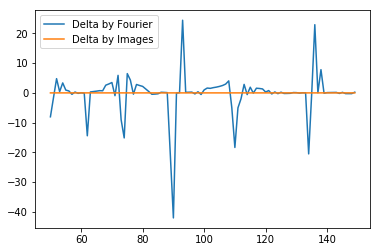

In [9]:
DI = []
DF = []
for i in range(50,150):
    fourier = DoubleBarrierFourier(K=100,L=90,U=110,T=1,sigma=.25,r=0.05)
    DF.append(fourier.Delta(i, 0))
    image = DoubleBarrierC(S = i, K = 100, L = 90, U = 110, t = 1, sigma = .25, r = 0.05)
    DI.append(image.Delta())
plt.plot([x for x in range(50, 150)], DF)
plt.plot([x for x in range(50, 150)], DI)
plt.legend(['Delta by Fourier', 'Delta by Images'])

Thus, we continue further tests using the image method and the Monte-Carlo method.

* **L = 80, U = 120**

In [10]:
DoubleBarrierC(S=100,K=100,L=80,U=120,t=0.5,sigma=0.25,r=0.05).Price()

1.4583205347007344

In [11]:
DoubleBarrierMC(S=100,K=100,L=80,U=120,t=0.5,sigma=0.25,r=0.05,n=10000)

(1.3858990474701622, 1.5512721892701964)

* **L = 70, U = 130**

In [12]:
DoubleBarrierC(S=100,K=100,L=70,U=130,t=0.5,sigma=0.25,r=0.05).Price()

3.7319849143551265

In [13]:
DoubleBarrierMC(S=100,K=100,L=70,U=130,t=0.5,sigma=0.25,r=0.05,n=10000)

(3.617406696018445, 3.9203091080471695)

* **Extreme Case: L = 0.1, U = 1000**

In [14]:
DoubleBarrierC(S=100,K=100,L=0.1,U=1000,t=0.5,sigma=0.25,r=0.05).Price()

8.26001519934323

In [15]:
DoubleBarrierMC(S=100,K=100,L=0.1,U=1000,t=0.5,sigma=0.25,r=0.05,n=10000)

KeyboardInterrupt: 

## 3. Tests for Validity
**(1)** Case 1: When the lower barrier is extremely small and the upper barrier is large enough, the double barrier knock-out call ption price should be equal with the vanilla call option price.

In [ ]:
# Vanilla Call Option Price
def BSC(S,K,t,sigma,r):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    return S*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)

In [ ]:
BSC(S=100,K=100,t=0.5,sigma=0.25,r=0.05)

In [ ]:
DoubleBarrierC(S=100,K=100,L=0.1,U=1000,t=0.5,sigma=0.25,r=0.05).Price()

(2) Case 2: If the upper barrier is large enough, then the double barrier knock-out call ption price should be equal with the single barrier knock-out call option price.

In [ ]:
def SingleBarrierC(S,K,X,t,sigma,r):
    k = r/(0.5*sigma**2)
    Price = BSC(S,K,t,sigma,r) - (S/X)**(-k+1)*BSC(X**2/S,K,t,sigma,r)
    return Price

In [ ]:
DoubleBarrierC(S=100,K=100,L=90,U=1000,t=0.5,sigma=0.25,r=0.05).Price()

In [ ]:
SingleBarrierC(S=100,K=100,X=90,t=0.5,sigma=0.25,r=0.05)

(3) Case 3: If time goes infinity, the knock out probability will approach 1, so the price will be nearly zero.

In [ ]:
DoubleBarrierC(S=100,K=100,L=90,U=110,t=100,sigma=0.25,r=0.05).Price()

## 4. Analytical Delta
* The analytical Delta has been stored in class "DoubleBarrierC"
* Test for it: if the lower barrier is extremely small and the upper barrier is large enough, the delta for the double barrier option will be equal with a vanilla call option's delta. 

In [ ]:
DoubleBarrierC(S=100,K=100,L=0.1,U=1000,t=0.5,sigma=0.25,r=0.05).Delta()

In [ ]:
norm.cdf((np.log(100/100)+(0.05+0.5*0.25**2)*0.5)/(0.25*np.sqrt(0.5)))

## 5. Empirical Study

In [ ]:
def ReplicationSeries(S,K,U,L,r,sigma):
    """
    Backtesting framework
    """
    P = pd.DataFrame(index = S.index, columns = ['V','delta','PnL'])
    T = S.size/252

    #computing option price and delta(equals portfolio value at time 0)
    DB = DoubleBarrierC(S=S[0],K=K,L=L,U=U,t=T,sigma=sigma,r=r)
    P.iloc[0,0]=DB.Price()
    P.iloc[0,1]=DB.Delta()
    
    for i in range(S.size-1):
        DB.update_params(S = S[i], t = T-i/252)
        P.iloc[i+1,1] = DB.Delta()
        P.iloc[i+1,0] = DB.Price()
        P.iloc[i+1,2]=(P.iloc[i+1,0]-P.iloc[i,0])-P.iloc[i,1]*(S[i+1]-S[i])
    return P   

def calc_proper_logreturns(dataseries):
    """
    Calculate logreturns that incorporate the days between entries/prices.
    """
    deltaT = (dataseries.index.to_series().shift(-1)-dataseries.index.to_series()) .dt.days
    logret = np.log(dataseries/dataseries.shift(1) )      / np.sqrt(deltaT).values
    return logret

### (1) MSFT

In [ ]:
stock1 = data.DataReader('MSFT', 'yahoo', '2019-05-15', '2020-05-14')['Adj Close']

sigma1 =  calc_proper_logreturns(stock1).std()* np.sqrt(252)
r = 0.0251
K1 = stock1[0]
U1 = stock1.max()
L1 = stock1.min()

In [ ]:
result1 = ReplicationSeries(stock1,K1,U1,L1,r,sigma1)
result1.head()

In [ ]:
plt.style.use("seaborn")
_ = plt.figure(figsize=(20,5))
_ = plt.plot(result1.PnL)

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(stock1)

In [ ]:
stock2 = data.DataReader('IBM', 'yahoo', '2019-05-15', '2020-05-14')['Adj Close']

sigma2 =  calc_proper_logreturns(stock2).std()* np.sqrt(252)
r = 0.0251
K2 = stock2[0]
U2 = stock2.max()
L2 = stock2.min()

In [ ]:
result2 = ReplicationSeries(stock2,K2,U2,L2,r,sigma2)
result2.head()

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(result2.PnL)

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(stock2)

### (3): CSCO

In [ ]:
stock3 = data.DataReader('CSCO', 'yahoo', '2019-05-15', '2020-05-14')['Adj Close']

In [ ]:
logret3 = calc_proper_logreturns(stock3)

In [ ]:
sigma3 = (logret3.std() * np.sqrt(252))
r = 0.0251
K3 = stock3[0]
U3 = stock3.max()+1
L3 = stock3.min()-1

In [ ]:
result3 = ReplicationSeries(stock3,K3,U3,L3,r,sigma3)
result3.head()

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(result3.PnL)

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(stock3)

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(result3.delta)

### (4): DELL

In [ ]:
stock4 = data.DataReader('DELL', 'yahoo', '2019-05-15', '2020-05-14')['Adj Close']

sigma4 =  calc_proper_logreturns(stock4).std()* np.sqrt(252)
r = 0.0251
K4 = stock4[0]
U4 = stock4.max()
L4 = stock4.min()

In [ ]:
result4 = ReplicationSeries(stock4,K4,U4,L4,r,sigma4)
result4.head()

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(result4.PnL)

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(stock4)

### (5): SNY

In [ ]:
stock5 = data.DataReader('SNY', 'yahoo', '2019-05-15', '2020-05-14')['Adj Close']

sigma5 =  calc_proper_logreturns(stock5).std()* np.sqrt(252)
r = 0.0251
K5 = stock5[0]
U5 = stock5.max()
L5 = stock5.min()

In [ ]:
result5 = ReplicationSeries(stock5,K5,U5,L5,r,sigma5)
result5.head()

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(result5.PnL)

In [ ]:
_ = plt.figure(figsize=(20,5))
_ = plt.plot(stock5)